## PREPARATION OF FELTOR INPUTS

FELTOR is a 3D gyro-fluid code that runs with quite a lot of input information that is not always intuitive. In this code, we create the input for FELTOR simulations from physical parameters and tuning the interested parameters*.

What we introduce:
- Physical parameters of the shot to be studied.
- Times at which we want outputs for 2D and 3D data and probe data
- Tuning of positions of synthetic probes.

What we get:
- Input json file with the parameters to run the desired simulation

*In case a more detailed description of input parameters and options is desired, the user should produce feltor.pdf with "pdflatex --shell-escape feltor.tex" in feltor/src/feltor.

In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import pandas as pd
import feltorutilities as fp   # thi repository
import magneticfielddb as mag  # https://github.com/feltor-dev/magneticfielddb
import simplesimdb as simplesim # in pypi or https://github.com/mwiesenberger/simplesimdb
from xfeltor import open_feltordataset # https://github.com/feltor-dev/xfeltor

In [2]:
#PHYSICAL PARAMETERS: Here we need to introduce the physical parameters that we will like to assume for 
# normalization in the code.
#T_e = electron temperature at the LCFS
#T_i = ion temperature at the LCFS
#n_0 = electron density in 10^19 m^-3 at the LCFS
#B_0 = magnetic field magnitude in T at the center of the core
#Mass of the ions: fp.proton/deuteron/triton_mass (for the moment only hydrogen)
#R = Major radius of the tokamaks to simulate
#a = minor radius of the tokamak to simulate
#q = q factor of the magnetic configuration simulated

physicals={"name" : "Compass",
    "T_e":10, "T_i": 10, "n_0" : 0.1, "B_0" : 0.07, "m_i" : fp.deuteron_mass,
    "R": 0.6,  "a" : 0.1, "q":2}


#----------------------------------------------------------# Not neccesary to change anything under this line


columns=[*physicals.keys(), *fp.quantities() ]
physicals["scaleR"] = 1.5 #ONLY USED FOR CFL CONDITION COMPUTATION. NOT RELEVANT
physicals["Nz"] = 32 #ONLY USED FOR CFL CONDITION COMPUTATION. NOT RELEVANT
data=( fp.parameters2quantities( physicals, columns))
show = ["name", "mu", "R_0", "a_0", "beta", "resistivity",
        "T_e", "n_0", "B_0", "CFL_diff", "epsilon_D",
        "omega_0_inv", "viscosity_i"]
df = pd.DataFrame( data, columns)

#Here we create the input parameters for physical and regularization
input_parameters={}
input_parameters["Physical"]={
"beta" : fp.parameters2quantity( physicals, "beta"),
"epsilon_D" : fp.parameters2quantity( physicals, "epsilon_D"),
"mu" : fp.parameters2quantity( physicals, "mu"),
"resistivity" : fp.parameters2quantity( physicals, "resistivity"),
"tau" : fp.parameters2quantity( physicals, "tau"),
"viscosity" : "value", #This parameter should be tuned with experience. It can also be set to "Braginskii"
"nu_parallel" : [ 6370, 196] #This parameter should be tuned
}

input_parameters["regularization"]= {
"direction" : "forward",
"nu_perp_n" : fp.parameters2quantity( physicals, "nu_perp"),
"nu_perp_u" : fp.parameters2quantity( physicals, "nu_perp"),
"nu_parallel_n": 8.6e2, #This parameter should be tuned with experience for numerical stability
"order" : 2
}

df

,0
name,Compass
T_e,10
T_i,10
n_0,0.1
B_0,0.07
m_i,0.0
R,0.6
a,0.1
q,2
rho_s,0.006526


In [3]:
#Here we define the time output parameters of the probes and the 2D data

DELTA_T_2D=0.1 #Time gap between 2D/3D Outputs in ms
Probe_frequency=1 #Probe frequency aquisition in MHz

#----------------------------------------------------------#  Not neccesary to change anything under this line

Omega_s_inv=fp.parameters2quantity( physicals, "omega_0_inv")
Delta_T_comp=int(DELTA_T_2D*1e-3/Omega_s_inv)
itstp=int(DELTA_T_2D*1e-3*(Probe_frequency*1e6))
input_parameters["output"]= {
    "compression" : [2,2], #Compression of output with respect to computational grid
    "itstp" : itstp,
    "maxout" : 200, #Maximum number of outputs
    "type" : "netcdf",
    "equations": #Definition of which equations are wanted to be studied and saved in output of simulation
    [ 
        "Basic",
        "Mass-conserv",
        "Energy-theorem",
        "Toroidal-momentum",
        "Parallel-momentum",
        "Zonal-Flow-Energy",
        "COCE"
    ]
}

input_parameters["timestepper"]={ #Definitions for time stepper. If changes are wanted, check feltor.pdf
    "tableau" : "Bogacki-Shampine-4-2-3",
    "type" : "adaptive",
    "atol" : 1e-6,
    "rtol" : 1e-5,
    "output-mode" : "deltaT",
    "deltaT" : Delta_T_comp,
    "reject-limit" : 10
}  


In [4]:
#MAGNETIC CONFIGURATION: Here we define which magnetic configuration we will like for our simulation.
#The magnetic configurations more easily accesible are the ones saved in the magneticfielddb library.

magnetic_constants = mag.select("enrx_tcv.json")
input_parameters["magnetic_field"]={
    "curvmode" : "toroidal",
    "input" : "params",
    "params" :  magnetic_constants
}

#In case it is desired to change the toroidal component of the magnetic field for unfavourable configuration,
#Uncomment the following line:
#input_parameters["magnetic_field"]["params"]["PI"]=-1.0

In [5]:
#Here we define the rest of input parameters for FELTOR simulations. Small comments are added for description, but 
#everything is better described in feltor.pdf
input_parameters["grid"]={
    "n" : 3, #Galerkin order method
    "Nx" : 208, #R direction dimension (real would be multiplied by n), must be divisable by 2^elliptic:stages
    "Ny" : 352, #Z direction dimension (real would be multiplied by n), must be divisable by 2^elliptic:stages
    "Nz" : 32, #Number of toroidal planes
    "scaleR" : [1.45,1.25], #Size in the R direction of the
    # box (in factors of minor radius a) from the center of the torus (left, right)
    "scaleZ" : [2.475,2.25] #Size in the Z direction of the box (in factors of minor radius a) (down, up)
}

input_parameters["advection"]={
    "slope-limiter" : "none"
}

input_parameters["boundary"]={ #For tuning of wall and SOL parameters, the use of calibrate.ipynb is recommended.
    "wall" :
    {
        "type" : "sol_pfr",
        "boundary" : [1.15, 0.95],
        "alpha" : [0.10,0.10],
        "penalization" : 1e-2,
        "modify-B" : True,
        "penalize-rhs" : True,
        "nwall" : 0.2,
        "uwall" : 0.0
    },
    "sheath" :
    {
        "type" : "insulating",
        "boundary" : 0.21875, 
        "alpha" : 0.15625, 
        "penalization" : 5.0, 
        "penalize-rhs" : True,
        "coordinate" : "s",
        "max_angle" : 4
    },
    "bc" :
    {
        "density" : ["NEU", "NEU"],
        "velocity": ["NEU", "NEU"],
        "potential":["DIR", "DIR"],
        "aparallel":["NEU", "NEU"]
    }
}

input_parameters["init"]={#For tuning of initial profiles parameters, the use of calibrate.ipynb is recommended.
    "type" : "fields",
    "density" :
    {
        "type" : "ne",
        "ntilde":
        {
            "type" : "turbulence",
            "amplitude" : 1e-4,
            "revolutions" : 1,
            "parallel" : "gaussian",
            "sigma_z" : 0.5
        },
        "profile": #There is not a way yet to introduce a density profile as an input for FELTOR, but it will be implemented
        {
            "type" : "aligned", #Density is proportional to the magnetic flux surfaces
            "npeak" : 8.5, #Core density
            "nsep" : 1.0, # Separatrix density
            "background" : 0.2 #Background density (small but not 0)
        },
        "damping":
        {
            "type" : "alignedPFR", #Damping of density in the SOL and in the Private flux region in rho terms
            "alpha" : [0.1,0.03],
            "boundary" : [1.15, 0.95]
        }
    },
    "potential": { "type" : "zero_pol"},
    "velocity":
    {
        "type" : "ui",
        "profile" : "linear_cs"
    },
    "aparallel": { "type" : "zero"}
}

input_parameters["source"]={
    "minne" : 0.2, 
    "minrate" : 1.0, 
    "minalpha" : 0.05, 
    "type" : "influx",
    "rate" : 1e-4,
    "profile":
    {
        "type" : "aligned",
        "npeak" : 1.0,
        "nsep" : 0.11765,
        "background" : 0.0
    },
    "ntilde" : {"type" : "zero"},
    "damping":
    {
        "type" : "alignedX",
        "alpha" : 0.2,
        "boundary" : 0.55
    }
}

input_parameters["elliptic"]={
    "stages": 5,
    "eps_pol" : [1e-6, 0.5, 0.5,0.5,0.5], 
    "eps_gamma" : 1e-8, 
    "eps_ampere" : 1e-8, 
    "direction" : "forward", 
    "jumpfactor" : 1.0
}

input_parameters["FCI"]={
    "refine" : [12,12], 
    "rk4eps" : 1e-6,
    "periodify" : False,
    "bc" : "along_field",
    "interpolation-method" : "linear-nearest"
}
input_parameters["flags"]=[]

In [6]:
#Here we run a quick simulation with the magnetic configuration decided previously to tune where we want to position the probes.
# It is defined with a less dense grid to make it quick enough

inputfile = fp.load_calibration_default()
inputfile["magnetic_field"]["params"] = input_parameters["magnetic_field"]["params"]
rho_s = fp.parameters2quantity( physicals, "rho_s")
scaleR = input_parameters["grid"]["scaleR"]
scaleZ = input_parameters["grid"]["scaleZ"]
inputfile["magnetic_field"]["params"]["R_0"]=inputfile["magnetic_field"]["params"]["R_0"]/rho_s
inputfile["magnetic_field"]["params"]["PI"]=1
inputfile["magnetic_field"]["params"]["PP"]=1
minor_radius = inputfile["magnetic_field"]["params"]["R_0"]*\
 inputfile["magnetic_field"]["params"]["inverseaspectratio"]
lR = (scaleR[1]+scaleR[0])*minor_radius
lZ = (scaleZ[1]+scaleZ[0])*minor_radius
inputfile["grid"] = {"Nx" : int(lR/2)*2, "Ny" : int(lZ/2)*2, "Nz": 1, "n": 1,
                     "scaleR" : scaleR, "scaleZ" : scaleZ}

rep = simplesim.Repeater( "./feltor.sh", "temp.json", "temp.nc")
rep.run( inputfile, error='display')

Text(0, 0.5, 'Z [mm]')

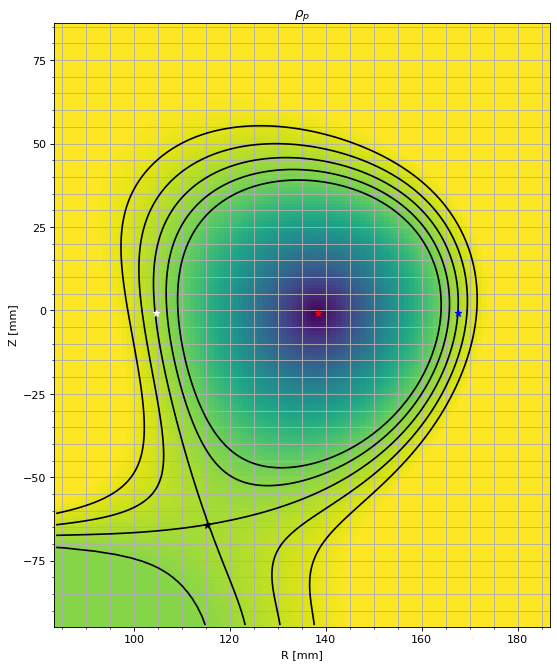

In [7]:
#Here we plot some of the magnetic surfaces and identify interesting positions for our probes like the X-point,
# the OMP or the IMP

#WARNING: In case you want to plot another configuration, you need to restart the kernel
ncin = open_feltordataset("temp.nc")


B_pol=ncin["BR"][0]*ncin["BR"][0]+ncin["BZ"][0]*ncin["BZ"][0] #We compute where the poloidal field is 0 to obtain the O and the X-point
new_x = np.linspace(ncin["x"][0], ncin["x"][-1], ncin.dims["x"] * 8) #We interpolate to a denser grid to have the points better defined than in the computed grid.
new_y = np.linspace(ncin["y"][0], ncin["y"][-1], ncin.dims["y"] * 8)
B_pol_interp=B_pol[0].interp(x=new_x, y=new_y)
rho_p_interp=ncin["Rho_p"][0].interp(x=new_x, y=new_y)

condition_X=np.where((rho_p_interp>=0.95)&(rho_p_interp<=1.05), B_pol_interp, 100)
condition_O=np.where(rho_p_interp<0.2, B_pol_interp, 100)
X_point=np.where(B_pol_interp==np.amin(condition_X)) #IN CASE OF DOUBLE NULL, ADD CONDITION TO OBTAIN UPPER AND DOWN X-points
O_point=np.where(B_pol_interp==np.amin(condition_O))
condition_MP_LCFS=np.where(rho_p_interp[O_point[0],:]<=1.0)
OMP_LCFS=[O_point[0][0],condition_MP_LCFS[1][-1]] 
IMP_LCFS=[O_point[0][0],condition_MP_LCFS[1][0]] 
#All the interesting points (X, 0, OMP_LCFS and IMP_LCFS) are defined as (y,x) coordinates!!!!


fig,ax=plt.subplots(figsize=(8,10),dpi= 80,facecolor='w', edgecolor='k')
ax.pcolormesh(ncin["x"], ncin["y"],ncin["Rho_p"][0])
ax.contour(,  new_y, rho_p_interp, [0.9,0.95,1, 1.05, 1.1], colors='k')
ax.plot([X_point[1]], new_y[X_point[0]], 'k*') #X-point
ax.plot([O_point[1]], new_y[O_point[0]], 'r*') #O-point
ax.plot([OMP_LCFS[1]], new_y[OMP_LCFS[0]], 'b*') #OMP at the LCFS
ax.plot([IMP_LCFS[1]], new_y[IMP_LCFS[0]], 'w*') #IMP at the LCFS
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax.xaxis.grid(which="both")
ax.yaxis.grid(which="both")    
ax.set_title( r"$\rho_p$")
ax.set_xlabel( "R [mm]")
ax.set_ylabel( "Z [mm]")
#ax.set_xlim([[OMP_LCFS[1]]-10,[OMP_LCFS[1]]+10])
#ax.set_ylim([new_y[OMP_LCFS[0]]-10,new_y[OMP_LCFS[0]]+10])

In [72]:
#Here we define the arrays of probes we are interested in. They are defined in R,Z coordinates in mm (as upper plot)
#We can define several arrays as it is done here
#The user can also define the R,Z positions of the probes from experimental coordinates, but the user
#should be certain that the 0 vertical position is defined in the same way between the code and the experiment.

R_probes_1=[new_x[OMP_LCFS[1]],new_x[OMP_LCFS[1]]+2,new_x[OMP_LCFS[1]]+4, new_x[OMP_LCFS[1]]+6, new_x[OMP_LCFS[1]]-2, new_x[OMP_LCFS[1]]-4 ]
Z_probes_1=[new_y[OMP_LCFS[0]],new_y[OMP_LCFS[0]],new_y[OMP_LCFS[0]],new_y[OMP_LCFS[0]],new_y[OMP_LCFS[0]],new_y[OMP_LCFS[0]]]
Probe_1=[R_probes_1,Z_probes_1]

R_probes_2=[new_x[OMP_LCFS[1]],new_x[OMP_LCFS[1]]+2,new_x[OMP_LCFS[1]]+4, new_x[OMP_LCFS[1]]+6, new_x[OMP_LCFS[1]]-2, new_x[OMP_LCFS[1]]-4 ]
Z_probes_2=np.subtract(Z_probes_1,2).tolist()
Probe_2=[R_probes_2,Z_probes_2]

R_probes_3=[50]
Z_probes_3=[20]
Probe_3

(-4.5695753362960545, 15.430424663703945)

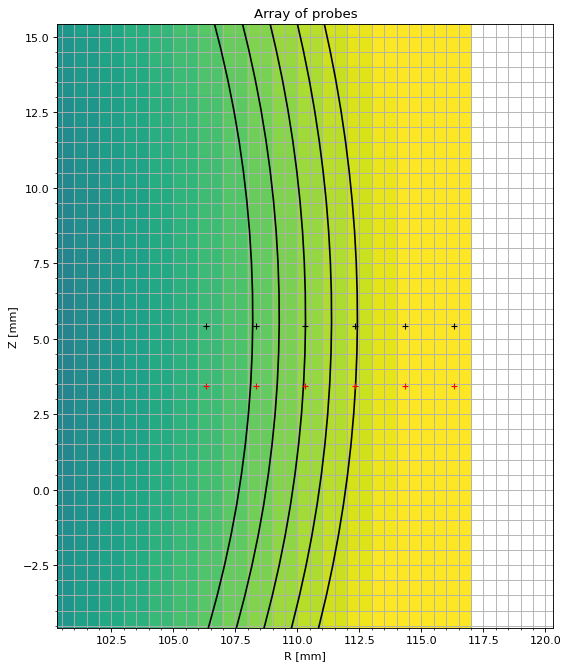

In [36]:
#Here we plot the probes arrays over the flux surfaces.

fig,ax=plt.subplots(figsize=(8,10),dpi= 80,facecolor='w', edgecolor='k')
ax.pcolormesh(ncin["x"], ncin["y"],ncin["Rho_p"][0])
ax.contour(new_x,  new_y, rho_p_interp, [0.9,0.95,1, 1.05, 1.1], colors='k')
ax.plot(Probe_1[0],Probe_1[1], 'k+')
ax.plot(Probe_2[0],Probe_2[1], 'r+')
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax.xaxis.grid(which="both")
ax.yaxis.grid(which="both")    
ax.set_title( r"Array of probes")
ax.set_xlabel( "R [mm]")
ax.set_ylabel( "Z [mm]")
ax.set_xlim([new_x[OMP_LCFS[1]]-10,new_x[OMP_LCFS[1]]+10]) #DEFINE THE REGION TO BE PLOTTED DEPENDING OF WHERE YOU POSITION YOUR PROBE
ax.set_ylim([new_y[OMP_LCFS[0]]-10,new_y[OMP_LCFS[0]]+10])

In [86]:
#Here the user should add all the coordinates of all the probes defined to be saved in the input file.
R_probe=Probe_1[0]+Probe_2[0] #Add the neccessary probes
Z_probe=Probe_1[1]+Probe_2[1] #Add the neccessary probes
Phi_probe=np.zeros(np.size(R_probe)).tolist() #It can be decided in which of the toroidal planes, the probes are positioned. This should not be extremely relevant.



input_parameters["probes"]={
"num_pins": np.size(R_probe), #Total number of pins of probes
"R_probe": R_probe/(rho_s*1e3), #Array with the R position of each pin in computational units
"Z_probe": Z_probe/(rho_s*1e3), #Array with the Z position of each pin in computational units
"phi_probe": Phi_probe #Array with the toroidal plane of each of the pins
}

In [24]:
#Here we create the input.json with the configuration set during the program
with open("input_created.json", "w") as outfile:
    json.dump(input_parameters, outfile, indent=4)